In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# import pickle  # optional
from prophet import Prophet
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression  # optional
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

### Load dataset

In [3]:
df = pd.read_csv('exports_all_countries.csv')
df.head()

Unnamed: 0  Unnamed: 1            Unnamed: 2 Unnamed: 3  \
NaN U.S. State   NaN     Partner         NaN               Product      Value   
1.0 South Dakota 1.0      Mexico         1.0  Pork & Pork Products     98,241   
                 1.0      Mexico         2.0              Soybeans     27,692   
                 1.0      Mexico         3.0  Beef & Beef Products     36,842   
                 1.0      Mexico         4.0                  Corn          0   

                      Unnamed: 4 Unnamed: 5    2014    2015    2016    2017  \
NaN U.S. State   NaN       Value      Value   Value   Value   Value   Value   
1.0 South Dakota 1.0      69,046     87,996  90,277  49,591  37,814  45,648   
                 1.0      19,720          0   4,996  39,686  33,673  61,917   
                 1.0      30,714     28,830  38,108  42,018  40,945  40,581   
                 1.0       6,205      6,747  13,822   2,327   4,065     113   

                          2018     2019     2020    2021  \
NaN U.S. State   NaN     Value    Value    Value   Value   
1.0 South Dakota 1.0   116,982  201,825  155,258  85,610   
                 1.0    13,040   38,134   63,784  66,733   
                 1.0    40,806   39,341   47,683  31,207   
                 1.0     9,495   10,578   16,390  26,468   

                                                  2022           2023  \
NaN U.S. State   NaN   Period/Period %  Change (Value)  Reporter Code   
1.0 South Dakota 1.0                               -45             SD   
                 1.0                                 5             SD   
                 1.0                               -35             SD   
                 1.0                                61             SD   

                               2024   Unnamed: 17  Unnamed: 18  
NaN U.S. State   NaN   Partner Code  Product Code          NaN  
1.0 South Dakota 1.0             MX        0210AT          NaN  
                 1.0             MX        0035AT          NaN  
                 1.0             MX        0205AT          NaN  
                 1.0             MX        0020AT          NaN

### Data Cleaning

In [4]:
#let's reload data and skip the first conlumn
df = pd.read_csv('exports_all_countries.csv', skiprows=1)

# Drop all unnamed columns that are entirely NaN
df = df.dropna(axis=1, how='all')

In [5]:
df.head()

,Unnamed: 0,U.S. State,Unnamed: 2,Partner,Unnamed: 4,Product,Value,Value.1,Value.2,Value.3,...,Value.5,Value.6,Value.7,Value.8,Value.9,Value.10,Period/Period % Change (Value),Reporter Code,Partner Code,Product Code
0,1.0,South Dakota,1.0,Mexico,1.0,Pork & Pork Products,"98,241","69,046","87,996","90,277",...,"37,814","45,648","116,982","201,825","155,258","85,610",-45,SD,MX,0210AT
1,1.0,South Dakota,1.0,Mexico,2.0,Soybeans,"27,692","19,720",0,"4,996",...,"33,673","61,917","13,040","38,134","63,784","66,733",5,SD,MX,0035AT
2,1.0,South Dakota,1.0,Mexico,3.0,Beef & Beef Products,"36,842","30,714","28,830","38,108",...,"40,945","40,581","40,806","39,341","47,683","31,207",-35,SD,MX,0205AT
3,1.0,South Dakota,1.0,Mexico,4.0,Corn,0,"6,205","6,747","13,822",...,"4,065",113,"9,495","10,578","16,390","26,468",61,SD,MX,0020AT
4,1.0,South Dakota,1.0,Mexico,5.0,Wheat,"12,104","5,821","5,067","9,798",...,"3,550","1,542","2,217","8,551","3,815","10,609",178,SD,MX,0015AT


In [6]:
# Rename columns: Map "Value", "Value.1", ..., "Value.10" to actual years
year_columns = {
    'Value': '2014',
    'Value.1': '2015',
    'Value.2': '2016',
    'Value.3': '2017',
    'Value.4': '2018',
    'Value.5': '2019',
    'Value.6': '2020',
    'Value.7': '2021',
    'Value.8': '2022',
    'Value.9': '2023',
    'Value.10': '2024',
}

df.rename(columns=year_columns, inplace=True)

In [7]:
#Drop any completely unnamed or redundant columns
df.drop(columns=[col for col in df.columns if 'Unnamed' in col], inplace=True)

In [8]:
df.head()

,U.S. State,Partner,Product,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Period/Period % Change (Value),Reporter Code,Partner Code,Product Code
0,South Dakota,Mexico,Pork & Pork Products,"98,241","69,046","87,996","90,277","49,591","37,814","45,648","116,982","201,825","155,258","85,610",-45,SD,MX,0210AT
1,South Dakota,Mexico,Soybeans,"27,692","19,720",0,"4,996","39,686","33,673","61,917","13,040","38,134","63,784","66,733",5,SD,MX,0035AT
2,South Dakota,Mexico,Beef & Beef Products,"36,842","30,714","28,830","38,108","42,018","40,945","40,581","40,806","39,341","47,683","31,207",-35,SD,MX,0205AT
3,South Dakota,Mexico,Corn,0,"6,205","6,747","13,822","2,327","4,065",113,"9,495","10,578","16,390","26,468",61,SD,MX,0020AT
4,South Dakota,Mexico,Wheat,"12,104","5,821","5,067","9,798","2,127","3,550","1,542","2,217","8,551","3,815","10,609",178,SD,MX,0015AT


In [9]:
# Check for and drop duplicate rows
df.drop_duplicates(inplace=True)


In [10]:
# Save cleaned dataset
df.to_csv("cleaned_south_dakota_exports.csv", index=False)

In [11]:
print("✅ Cleaned dataset saved as 'cleaned_south_dakota_exports.csv'")

✅ Cleaned dataset saved as 'cleaned_south_dakota_exports.csv'


### EDA

In [12]:
df1 = pd.read_csv('cleaned_south_dakota_exports.csv')
df1.head()

,U.S. State,Partner,Product,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Period/Period % Change (Value),Reporter Code,Partner Code,Product Code
0,South Dakota,Mexico,Pork & Pork Products,"98,241","69,046","87,996","90,277","49,591","37,814","45,648","116,982","201,825","155,258","85,610",-45,SD,MX,0210AT
1,South Dakota,Mexico,Soybeans,"27,692","19,720",0,"4,996","39,686","33,673","61,917","13,040","38,134","63,784","66,733",5,SD,MX,0035AT
2,South Dakota,Mexico,Beef & Beef Products,"36,842","30,714","28,830","38,108","42,018","40,945","40,581","40,806","39,341","47,683","31,207",-35,SD,MX,0205AT
3,South Dakota,Mexico,Corn,0,"6,205","6,747","13,822","2,327","4,065",113,"9,495","10,578","16,390","26,468",61,SD,MX,0020AT
4,South Dakota,Mexico,Wheat,"12,104","5,821","5,067","9,798","2,127","3,550","1,542","2,217","8,551","3,815","10,609",178,SD,MX,0015AT


In [13]:
print(df1.columns.tolist())

['U.S. State', 'Partner', 'Product', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 'Period/Period %  Change (Value)', 'Reporter Code', 'Partner Code', 'Product Code']


In [14]:
# Display basic info
print("🔍 Dataset Summary:")
print(df1.info())

🔍 Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   U.S. State                       161 non-null    object
 1   Partner                          160 non-null    object
 2   Product                          160 non-null    object
 3   2014                             161 non-null    object
 4   2015                             161 non-null    object
 5   2016                             161 non-null    object
 6   2017                             161 non-null    object
 7   2018                             161 non-null    object
 8   2019                             161 non-null    object
 9   2020                             161 non-null    object
 10  2021                             161 non-null    object
 11  2022                             161 non-null    object
 12  2023             

In [15]:
# Check for missing values
print("\n❓ Missing Values:")
print(df1.isnull().sum())



❓ Missing Values:
U.S. State                          0
Partner                             1
Product                             1
2014                                0
2015                                0
2016                                0
2017                                0
2018                                0
2019                                0
2020                                0
2021                                0
2022                                0
2023                                0
2024                                0
Period/Period %  Change (Value)    99
Reporter Code                       1
Partner Code                        1
Product Code                        1
dtype: int64


In [16]:
# Check unique values in key columns
print("\n📌 Unique Products:")
print(df1['Product'].unique())


📌 Unique Products:
['Pork & Pork Products' 'Soybeans' 'Beef & Beef Products' 'Corn' 'Wheat'
 'Dairy Products' 'Soybean meal' 'Soybean Oil' 'Hay' nan]


In [17]:
# Convert year columns to numeric
year_cols = [str(year) for year in range(2014, 2025)]
df1[year_cols] = df1[year_cols].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

In [18]:
# Check descriptive statistics
print("\n📈 Descriptive Statistics:")
print(df1[year_cols].describe())


📈 Descriptive Statistics:
                2014           2015           2016           2017  \
count     161.000000     161.000000     161.000000     161.000000   
mean     6215.279503    4913.167702    4781.111801    4789.645963   
std     41650.601046   32735.024085   32023.259556   32202.973715   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%       168.000000     114.000000     295.000000     126.000000   
max    500328.000000  395510.000000  384880.000000  385566.000000   

                2018           2019           2020           2021  \
count     161.000000     161.000000     161.000000     161.000000   
mean     4808.186335    4840.552795    6130.776398    7999.919255   
std     31903.479824   31908.887878   40442.992733   52801.435089   
min         0.000000       0.000000       0.000000       0.000000   
25%   

In [19]:
# Plot export trends for each major product
top_products = df1['Product'].value_counts().index[:5]  # You can change the number here
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

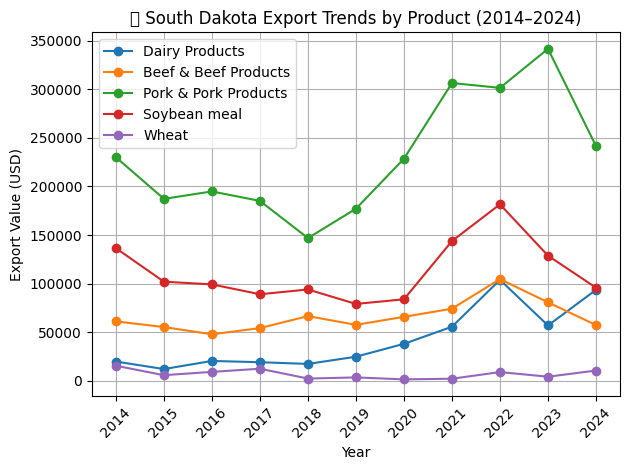

In [20]:
for product in top_products:
    product_data = df1[df1['Product'] == product][year_cols].sum()
    plt.plot(year_cols, product_data, marker='o', label=product)

plt.title("📦 South Dakota Export Trends by Product (2014–2024)")
plt.xlabel("Year")
plt.ylabel("Export Value (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

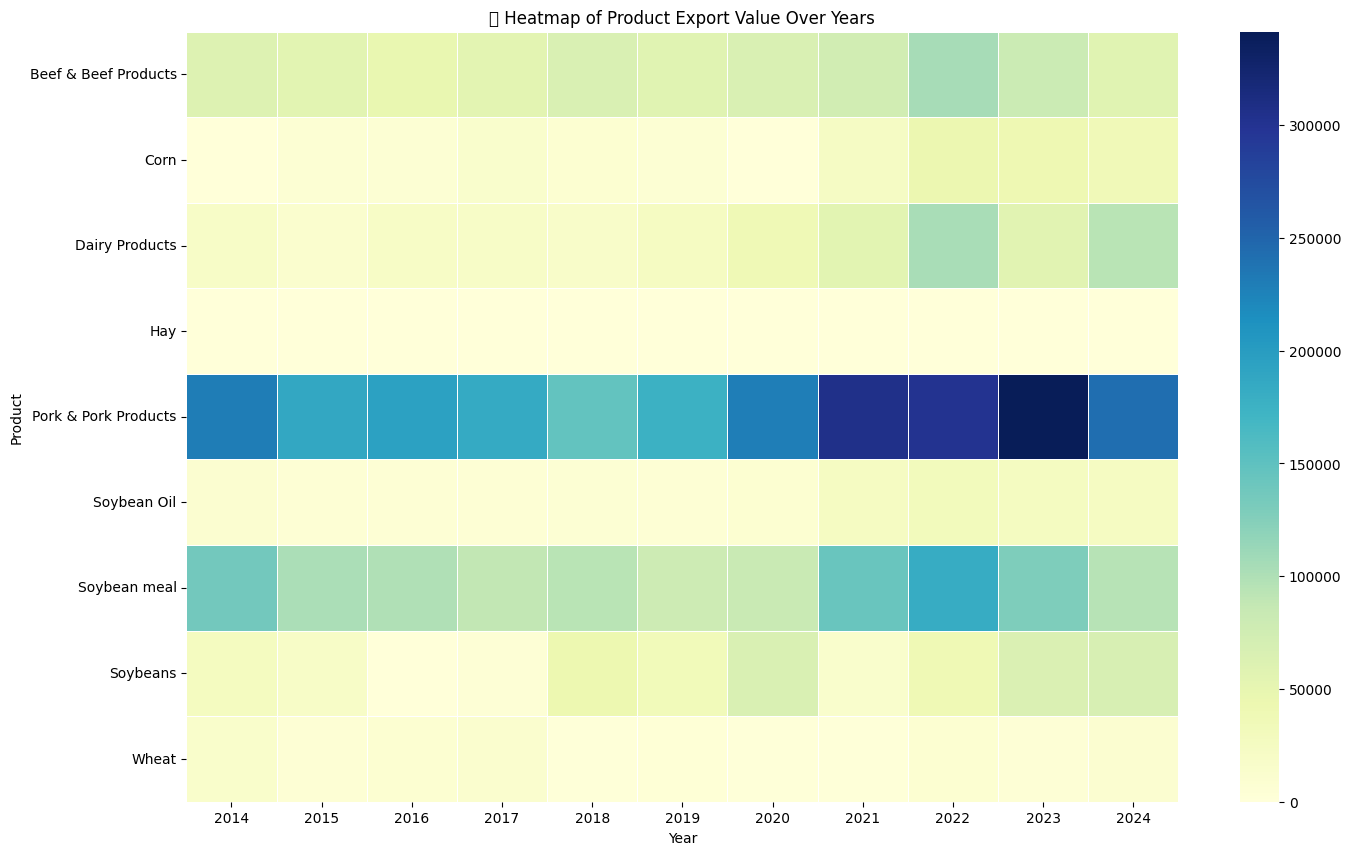

In [21]:
# Heatmap of export values per year
pivot = df1.pivot_table(index='Product', values=year_cols, aggfunc='sum')
plt.figure(figsize=(16, 10))
sns.heatmap(pivot, cmap="YlGnBu", annot=False, linewidths=.5)
plt.title("🌡️ Heatmap of Product Export Value Over Years")
plt.xlabel("Year")
plt.ylabel("Product")
plt.show()

## 🧪 Step-by-Step Code: Split & Train

In [22]:
# Step 1: Strip whitespace from column names
df.columns = df1.columns.str.strip()


In [23]:
# Step 2: Melt year columns into long format
year_cols = [col for col in df.columns if col.isdigit()]
df_melted = df1.melt(id_vars=['U.S. State', 'Partner', 'Product'], 
                    value_vars=year_cols, 
                    var_name='Year', value_name='Export_Value')


In [24]:
# Step 3: Convert Year to datetime
df_melted['Year'] = pd.to_datetime(df_melted['Year'], format='%Y')


In [25]:
# Step 4: Aggregate (optional, total export per year)
df_prophet = df_melted.groupby('Year')['Export_Value'].sum().reset_index()

In [26]:
# Step 5: Rename columns for Prophet
df_prophet = df_prophet.rename(columns={'Year': 'ds', 'Export_Value': 'y'})

In [28]:
# Final structure: Prophet-ready
print(df_prophet.head(30))

           ds        y
0  2014-01-01  1000660
1  2015-01-01   791020
2  2016-01-01   769759
3  2017-01-01   771133
4  2018-01-01   774118
5  2019-01-01   779329
6  2020-01-01   987055
7  2021-01-01  1287987
8  2022-01-01  1631390
9  2023-01-01  1487775
10 2024-01-01  1252417


In [200]:
print(df_prophet.columns)


Index(['ds', 'y'], dtype='object')


### Split: Train 

In [201]:
# Split: Train up to 2022, forecast beyond
train = df_prophet[df_prophet['ds'].dt.year <= 2022]
test = df_prophet[df_prophet['ds'].dt.year > 2022]

In [179]:
print(df_prophet.dtypes)
print(df_prophet.head())


ds    datetime64[ns]
y              int64
dtype: object
          ds        y
0 2014-01-01  1000660
1 2015-01-01   791020
2 2016-01-01   769759
3 2017-01-01   771133
4 2018-01-01   774118


In [180]:
print(df_prophet.shape)
print(df_prophet.head(10))
print(df_prophet.describe())

(11, 2)
          ds        y
0 2014-01-01  1000660
1 2015-01-01   791020
2 2016-01-01   769759
3 2017-01-01   771133
4 2018-01-01   774118
5 2019-01-01   779329
6 2020-01-01   987055
7 2021-01-01  1287987
8 2022-01-01  1631390
9 2023-01-01  1487775
                                  ds             y
count                             11  1.100000e+01
mean   2019-01-01 02:10:54.545454592  1.048422e+06
min              2014-01-01 00:00:00  7.697590e+05
25%              2016-07-02 00:00:00  7.767235e+05
50%              2019-01-01 00:00:00  9.870550e+05
75%              2021-07-02 12:00:00  1.270202e+06
max              2024-01-01 00:00:00  1.631390e+06
std                              NaN  3.172360e+05


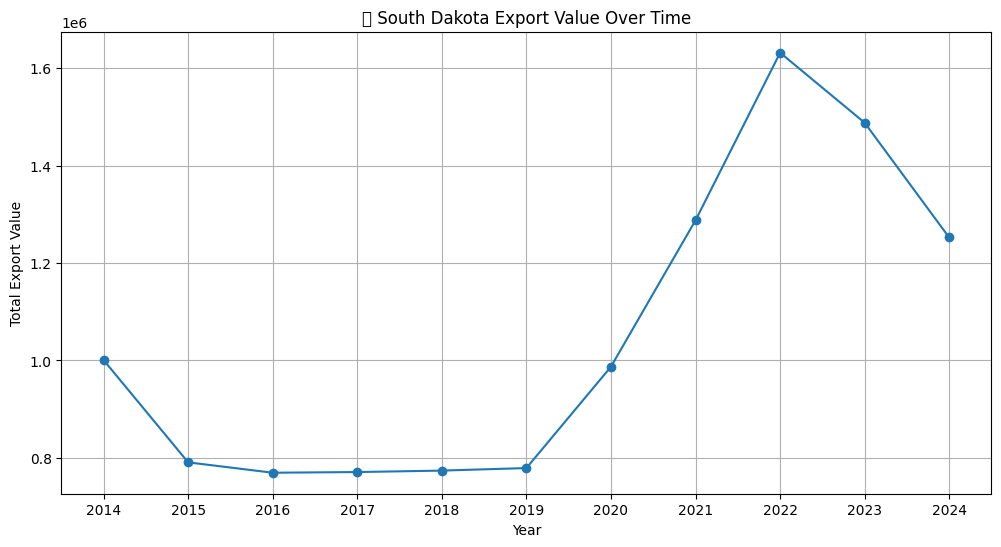

In [204]:
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], marker='o')
plt.title("📦 South Dakota Export Value Over Time")
plt.xlabel("Year")
plt.ylabel("Total Export Value")
plt.grid(True)
plt.show()


In [205]:
#📍 Forecast into the future (up to last date in test set)
# ---------------------------------------
future = model.make_future_dataframe(periods=len(test), freq='Y')
forecast = model.predict(future)

In [206]:
# 📍 Merge actual and predicted values
# ---------------------------------------
# Only keep forecasted years in test set
forecast_test = forecast[forecast['ds'].isin(test['ds'])]
merged = test.merge(forecast_test[['ds', 'yhat']], on='ds')

In [207]:
# Remove commas and convert to numeric
df_prophet['y'] = df_prophet['y'].astype(str).str.replace(',', '').astype(float)


In [208]:
# Clean the y column
df_prophet['y'] = df_prophet['y'].astype(str).str.replace(',', '').astype(float)

# Fit the model
from prophet import Prophet
model = Prophet()
model.fit(df_prophet)

# Make future dataframe and forecast
future = model.make_future_dataframe(periods=30)  # adjust periods as needed
forecast = model.predict(future)

# Merge actual and predicted values
df_eval = df_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
rmse = mean_squared_error(df_eval['y'], df_eval['yhat']) ** 0.5  # Manual RMSE

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


17:39:05 - cmdstanpy - INFO - Chain [1] start processing
17:39:05 - cmdstanpy - INFO - Chain [1] done processing


MAE: 155298.04
RMSE: 188193.33


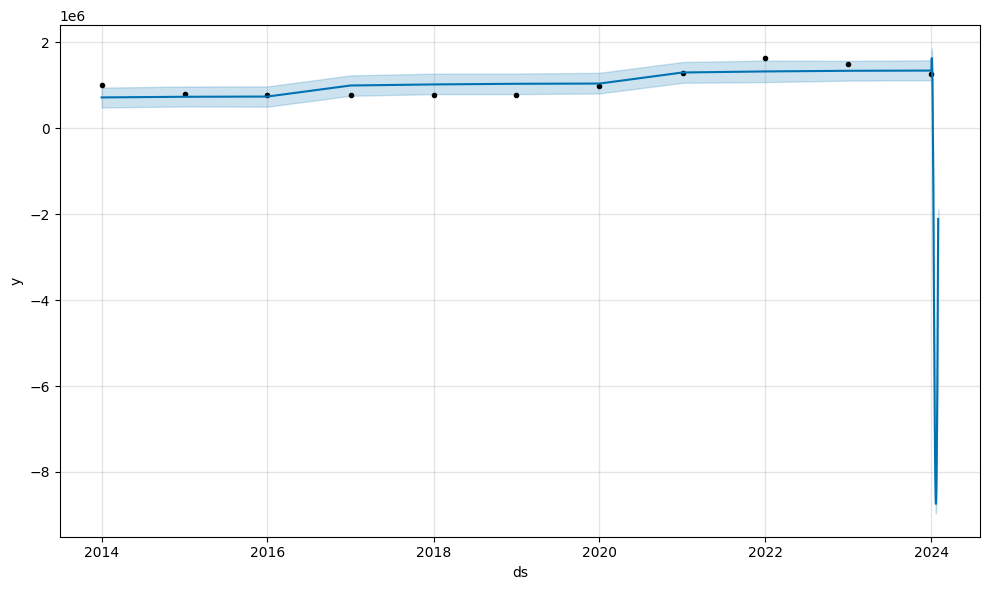

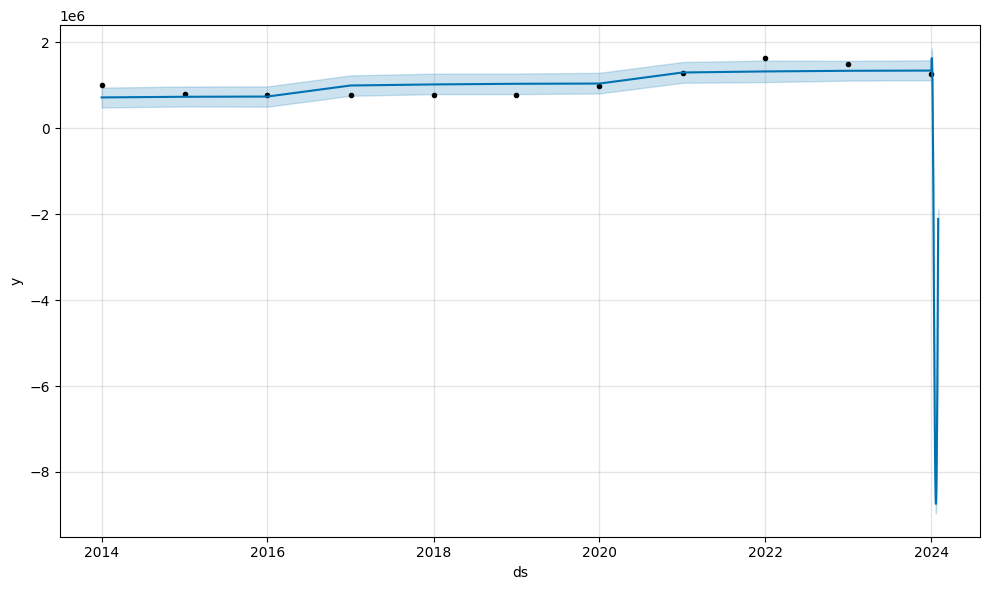

In [209]:
model.plot(forecast)
